In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Using TensorFlow backend.

In [3]:
data = pd.read_csv("data_set/application_record.csv", encoding ='utf-8')
record = pd.read_csv("data_set/credit_record.csv", encoding ='utf-8')

In [4]:
plt.rcParams['figure.facecolor'] = 'white'

## Feature Engineering
-  Response Variable

In [5]:
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'})
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

- adjust the STATUS mapping based on dep_value > 2 (90+ days past due).

In [6]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='3']='Yes'
record['dep_value'][record['STATUS'] =='4']='Yes'
record['dep_value'][record['STATUS'] =='5']='Yes' 

# label target each row(application)

In [7]:
cpunt=record.groupby('ID').count()

In [8]:
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' # bad_dept
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' # good_dept

In [9]:
cpunt = cpunt[['dep_value']] #make cpunt ID and dep_value pair 
new_data = pd.merge(new_data,cpunt,how='inner',on='ID') 
new_data['target'] = new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target'] = 1
new_data.loc[new_data['target']=='No','target'] = 0

# Calculate Applicant Age and Years of Working

In [10]:
# Calculate Applicant Age and Years of Working
new_data["APPLICATION_AGE"] = -new_data["DAYS_BIRTH"] // 365
new_data["YEARS_OF_WORKING"] = -new_data["DAYS_EMPLOYED"] // 365

# Drop rows where either Years_of_Working is negative

In [11]:
# Drop rows where either Years_of_Working is negative
new_data = new_data[
    (new_data['YEARS_OF_WORKING'] >= 0)
    ]

# Drop column before we have cal 
   - DAYS_BIRTH to APPLICATION_AGE
   - DAYS_EMPLOYED to YEARS_OF_WORKS
   - dep_value and begin_month we receive target label so not use anymore 

In [12]:
new_data = new_data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED','dep_value', 'begin_month'], axis=1)

## Normalization 
- AMT_INCOME_TOTAL (Z-score for data that have many outlier like income this may have effect to the other data)

In [13]:
# For Z-score normalization
scaler_zscore = StandardScaler()
zscore_cols = ['AMT_INCOME_TOTAL']
# Create new column names for normalized features
zscore_cols_scaled = [col + '_zscore' for col in zscore_cols]
# Transform and assign to new columns
new_data[zscore_cols_scaled] = scaler_zscore.fit_transform(new_data[zscore_cols])


In [14]:
# Drop after we have z-score
new_data = new_data.drop(['AMT_INCOME_TOTAL'], axis=1)

# Apply filtering conditions
- for credit card age 21 may not have eligible to approve
- other column that may have null

In [15]:
# Apply filtering conditions
filtered_application_df = new_data[
    (new_data["APPLICATION_AGE"] >= 21) &
    new_data["CODE_GENDER"].notnull() &
    new_data["FLAG_OWN_CAR"].notnull() &
    new_data["FLAG_OWN_REALTY"].notnull() &
    new_data["CNT_CHILDREN"].notnull() &
    new_data["NAME_INCOME_TYPE"].notnull() &
    new_data["NAME_EDUCATION_TYPE"].notnull() &
    new_data["NAME_FAMILY_STATUS"].notnull() &
    new_data["NAME_HOUSING_TYPE"].notnull()
    ]

### check FLAG_MOBIL to may not import because every record have value 1 I don't know why 
- so i would like to drop it

In [16]:
filtered_application_df['FLAG_MOBIL'].value_counts()

FLAG_MOBIL
1    30321
Name: count, dtype: int64

In [17]:
filtered_application_df = filtered_application_df.drop(['FLAG_MOBIL'], axis=1)

In [18]:
# target to type int 
filtered_application_df['target'] = new_data['target'].astype(int)

## handle with null and NAN
- drop null and NAN before 30321 after 25133

In [19]:
filtered_application_df.dropna()
filtered_application_df = filtered_application_df.mask(filtered_application_df == 'NULL').dropna()
filtered_application_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target,APPLICATION_AGE,YEARS_OF_WORKING,AMT_INCOME_TOTAL_zscore
2,5008806,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,0,58,3,-0.783777
3,5008808,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,0,52,8,0.723608
4,5008809,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,0,52,8,0.723608
5,5008810,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,0,52,8,0.723608
6,5008811,F,N,Y,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,0,52,8,0.723608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Managers,2.0,1,47,6,1.154290
36453,5149834,F,N,Y,0,Commercial associate,Higher education,Married,House / apartment,0,1,1,Medicine staff,2.0,1,33,3,-0.353096
36454,5149838,F,N,Y,0,Pensioner,Higher education,Married,House / apartment,0,1,1,Medicine staff,2.0,1,33,3,-0.353096
36455,5150049,F,N,Y,0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Sales staff,2.0,0,49,1,0.852813


## Features

In [20]:
ivtable=pd.DataFrame(filtered_application_df.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

- Define calc_iv function to calculate -> https://www.kaggle.com/code/puremath86/iv-woe-starter-for-python Information Value and WOE Value

# Binary Features


In [21]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [22]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [23]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut

    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- Gender

In [25]:
filtered_application_df['CODE_GENDER'] = filtered_application_df['CODE_GENDER'].replace(['F','M'],[0,1])
print(filtered_application_df['CODE_GENDER'].value_counts())
iv, data = calc_iv(filtered_application_df,'CODE_GENDER','target')
ivtable.loc[ivtable['variable']=='CODE_GENDER','IV']=iv
data.head()

CODE_GENDER
0    15629
1     9504
Name: count, dtype: int64
This variable's IV is: 0.023628136136266492
CODE_GENDER
0    15629
1     9504
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,CODE_GENDER,0,15629,15518,111,0.621852,0.007102,0.622463,0.546798,0.129605,0.009807
1,CODE_GENDER,1,9504,9412,92,0.378148,0.009680,0.377537,0.453202,-0.182669,0.013822


- Having a car or not

In [26]:
filtered_application_df['FLAG_OWN_CAR'] = filtered_application_df['FLAG_OWN_CAR'].replace(['N','Y'],[0,1])
print(filtered_application_df['FLAG_OWN_CAR'].value_counts())
iv, data=calc_iv(filtered_application_df,'FLAG_OWN_CAR','target')
ivtable.loc[ivtable['variable']=='FLAG_OWN_CAR','IV']=iv
data.head()

FLAG_OWN_CAR
0    14618
1    10515
Name: count, dtype: int64
This variable's IV is: 8.779280833932987e-05
FLAG_OWN_CAR
0    14618
1    10515
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,FLAG_OWN_CAR,0,14618,14499,119,0.581626,0.008141,0.581588,0.586207,-0.007910,0.000037
1,FLAG_OWN_CAR,1,10515,10431,84,0.418374,0.007989,0.418412,0.413793,0.011099,0.000051


- Having house reality or not¶

In [27]:
filtered_application_df['FLAG_OWN_REALTY'] = filtered_application_df['FLAG_OWN_REALTY'].replace(['N','Y'],[0,1])
print(filtered_application_df['FLAG_OWN_REALTY'].value_counts())
iv, data=calc_iv(filtered_application_df,'FLAG_OWN_REALTY','target')
ivtable.loc[ivtable['variable']=='FLAG_OWN_REALTY','IV']=iv
data.head()

FLAG_OWN_REALTY
1    16460
0     8673
Name: count, dtype: int64
This variable's IV is: 0.012673064096649079
FLAG_OWN_REALTY
1    16460
0     8673
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,FLAG_OWN_REALTY,0,8673,8592,81,0.345084,0.009339,0.344645,0.399015,-0.146484,0.007964
1,FLAG_OWN_REALTY,1,16460,16338,122,0.654916,0.007412,0.655355,0.600985,0.086607,0.004709


- Having a phone or not

In [28]:
filtered_application_df['FLAG_PHONE']=filtered_application_df['FLAG_PHONE'].astype(int)
print(filtered_application_df['FLAG_PHONE'].value_counts(normalize=True,sort=False))
filtered_application_df.drop(filtered_application_df[filtered_application_df['FLAG_PHONE'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'FLAG_PHONE','target')
ivtable.loc[ivtable['variable']=='FLAG_PHONE','IV']=iv
data.head()

FLAG_PHONE
0    0.707237
1    0.292763
Name: proportion, dtype: float64
This variable's IV is: 0.017224481781277095
FLAG_PHONE
0    21342
1     8980
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,FLAG_PHONE,0,21342,21189,153,0.703845,0.007169,0.704328,0.642857,0.091321,0.005614
1,FLAG_PHONE,1,8980,8895,85,0.296155,0.009465,0.295672,0.357143,-0.188885,0.011611


- Having an email or not

In [29]:
print(filtered_application_df['FLAG_EMAIL'].value_counts(normalize=True,sort=False))
filtered_application_df['FLAG_EMAIL']=filtered_application_df['FLAG_EMAIL'].astype(int)
iv, data=calc_iv(new_data,'FLAG_EMAIL','target')
ivtable.loc[ivtable['variable']=='FLAG_EMAIL','IV']=iv
data.head()

FLAG_EMAIL
0    0.899375
1    0.100625
Name: proportion, dtype: float64
This variable's IV is: 0.00455672695552156
FLAG_EMAIL
0    27265
1     3057
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,FLAG_EMAIL,0,27265,27056,209,0.899182,0.007666,0.899348,0.878151,0.023852,0.000506
1,FLAG_EMAIL,1,3057,3028,29,0.100818,0.009486,0.100652,0.121849,-0.191116,0.004051


- Having a Work Phone or not

In [30]:
filtered_application_df['FLAG_WORK_PHONE']=filtered_application_df['FLAG_WORK_PHONE'].astype(str)
iv, data = calc_iv(filtered_application_df,'FLAG_WORK_PHONE','target')
new_data.drop(filtered_application_df[filtered_application_df['FLAG_WORK_PHONE'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='FLAG_WORK_PHONE','IV']=iv
data.head()

This variable's IV is: 0.0007133590889604317
FLAG_WORK_PHONE
0    18251
1     6882
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,FLAG_WORK_PHONE,0,18251,18106,145,0.726177,0.007945,0.726274,0.714286,0.016644,0.000200
1,FLAG_WORK_PHONE,1,6882,6824,58,0.273823,0.008428,0.273726,0.285714,-0.042863,0.000514


## Plot corr of numerical data in this data set 
   - binary is 
      - FLAG_OWN_REALTY
      - FLAG_OWN_CAR
      - CODE_GENDER
      - FLAG_WORK_PHONE 
      - FLAG_EMAIL
      - FLAG_PHONE

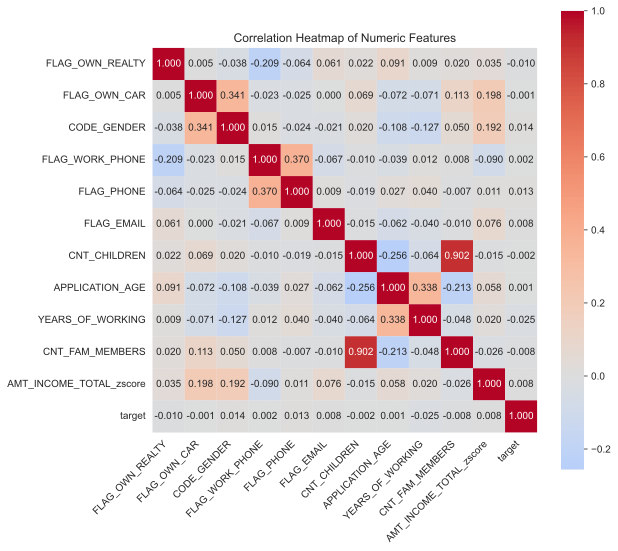

In [31]:
numeric_cols = ['FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'CODE_GENDER', 
                'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
                'CNT_CHILDREN', 'APPLICATION_AGE', 'YEARS_OF_WORKING',
                'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL_zscore','target']

# Calculate correlation matrix
correlation_matrix = filtered_application_df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(9, 8))
sns.heatmap(correlation_matrix,
            annot=True,  # Show numbers
            cmap='coolwarm',  # Red/Blue color scheme
            center=0,  # Center the colorbar at 0
            fmt='.3f',  # 2 decimal places
            square=True)  # Make cells square

plt.title('Correlation Heatmap of Numeric Features')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Continuous Variables
- For Children Numbers, which is a continuous variable, True/False Encoding is used. Then, the IV (Information Value) of each group is compared, and the top 2 groups with the highest IV are selected for further analysis.
    - Since we are selecting the top 2 groups with the highest IV:
	- 2 or more children (0.003664)
	- 1 child (0.000660)

In [32]:
filtered_application_df.loc[filtered_application_df['CNT_CHILDREN'] >= 2,'CNT_CHILDREN']='2More'
print(filtered_application_df['CNT_CHILDREN'].value_counts(sort=False))

CNT_CHILDREN
0        15907
2More     3108
1         6118
Name: count, dtype: int64


In [33]:
iv, data=calc_iv(filtered_application_df,'CNT_CHILDREN','target')
ivtable.loc[ivtable['variable']=='CNT_CHILDREN','IV']=iv
data.head()

This variable's IV is: 0.004413547062632149
CNT_CHILDREN
0        15907
1         6118
2More     3108
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,CNT_CHILDREN,0,15907,15777,130,0.632913,0.008173,0.632852,0.640394,-0.011847,0.000089
1,CNT_CHILDREN,1,6118,6066,52,0.243425,0.008500,0.243321,0.256158,-0.051410,0.000660
2,CNT_CHILDREN,2More,3108,3087,21,0.123662,0.006757,0.123827,0.103448,0.179811,0.003664


In [34]:
filtered_application_df = convert_dummy(filtered_application_df,'CNT_CHILDREN')

## Age
- Bucketing Continuous Variables

In [ ]:
# new_data['Age']=-(new_data['DAYS_BIRTH'])//365
# print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
# new_data['Age'].plot(kind='hist',bins=20,density=True)

In [ ]:
# new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
# iv, data = calc_iv(new_data,'gp_Age','target')
# ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
# data.head()

In [ ]:
# new_data = convert_dummy(new_data,'gp_Age')

## Age
- Z-score Continuous Variables

In [36]:
# For Z-score normalization
scaler_zscore = StandardScaler()
zscore_cols = ['APPLICATION_AGE']
# Create new column names for normalized features
zscore_cols_scaled = [col + '_zscore' for col in zscore_cols]
# Transform and assign to new columns
filtered_application_df[zscore_cols_scaled] = scaler_zscore.fit_transform(filtered_application_df[zscore_cols])

In [37]:
filtered_application_df = filtered_application_df.drop(['APPLICATION_AGE'], axis=1)

## Working Years 
- Equal-length Bucketing

In [ ]:
# new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
# new_data[new_data['worktm']<0] = np.nan # replace by na
# new_data['DAYS_EMPLOYED']
# new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean
# print(new_data['worktm'].value_counts(bins=20,normalize=True,sort=False))
# new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [ ]:
# new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
# iv, data=calc_iv(new_data,'gp_worktm','target')
# ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
# data.head()

In [ ]:
# new_data = convert_dummy(new_data,'gp_worktm')

## Working Years 
- Min-Max

In [41]:
from sklearn.preprocessing import MinMaxScaler

# วิธีใช้ Min-Max
scaler = MinMaxScaler()
filtered_application_df['YEARS_OF_WORKING_normalized'] = scaler.fit_transform(filtered_application_df[['YEARS_OF_WORKING']])
filtered_application_df = filtered_application_df.drop(['YEARS_OF_WORKING'], axis=1)

- Family Size
- For CNT_FAM_MEMBERS, which is a continuous variable, True/False Encoding is used. Then, the IV (Information Value) of each group is compared, and the top 2 groups with the highest IV are selected for further analysis.
    - Since we are selecting the top 2 groups with the highest IV:
	- 3 or more  (0.011779)
	- 1  (0.003951)

In [44]:
filtered_application_df['CNT_FAM_MEMBERS'].value_counts(sort=False)

CNT_FAM_MEMBERS
2.0     12697
1.0      4262
5.0       307
3.0      5216
4.0      2576
6.0        51
15.0        3
7.0        18
20.0        1
9.0         2
Name: count, dtype: int64

In [45]:
filtered_application_df['CNT_FAM_MEMBERS']=filtered_application_df['CNT_FAM_MEMBERS'].astype(int)
filtered_application_df['CNT_FAM_MEMBERS']=filtered_application_df['CNT_FAM_MEMBERS']
filtered_application_df['CNT_FAM_MEMBERS']=filtered_application_df['CNT_FAM_MEMBERS'].astype(object)
filtered_application_df.loc[filtered_application_df['CNT_FAM_MEMBERS']>=3,'CNT_FAM_MEMBERS']='3more'
iv, data=calc_iv(filtered_application_df,'CNT_FAM_MEMBERS','target')
ivtable.loc[ivtable['variable']=='CNT_FAM_MEMBERS','IV']=iv
data.head()

This variable's IV is: 0.016052843301034694
CNT_FAM_MEMBERS
2        12697
3more     8174
1         4262
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,CNT_FAM_MEMBERS,1,4262,4218,44,0.169578,0.010324,0.169194,0.216749,-0.247694,0.011779
1,CNT_FAM_MEMBERS,2,12697,12597,100,0.505192,0.007876,0.505295,0.492611,0.025423,0.000322
2,CNT_FAM_MEMBERS,3more,8174,8115,59,0.325230,0.007218,0.325511,0.290640,0.113311,0.003951


In [46]:
filtered_application_df = convert_dummy(filtered_application_df,'CNT_FAM_MEMBERS')

### Categorical Features all True/False Encoding is used.
- Income Type

In [48]:
print(filtered_application_df['NAME_INCOME_TYPE'].value_counts(sort=False))
print(filtered_application_df['NAME_INCOME_TYPE'].value_counts(normalize=True,sort=False))
filtered_application_df.loc[filtered_application_df['NAME_INCOME_TYPE']=='Pensioner','NAME_INCOME_TYPE']='State servant'
filtered_application_df.loc[filtered_application_df['NAME_INCOME_TYPE']=='Student','NAME_INCOME_TYPE']='State servant'
iv, data=calc_iv(filtered_application_df,'NAME_INCOME_TYPE','target')
ivtable.loc[ivtable['variable']=='NAME_INCOME_TYPE','IV']=iv
data.head()

NAME_INCOME_TYPE
Working                 15622
Commercial associate     7051
State servant            2437
Student                    10
Pensioner                  13
Name: count, dtype: int64
NAME_INCOME_TYPE
Working                 0.621573
Commercial associate    0.280547
State servant           0.096964
Student                 0.000398
Pensioner               0.000517
Name: proportion, dtype: float64
This variable's IV is: 0.016796668855467475
NAME_INCOME_TYPE
Working                 15622
Commercial associate     7051
State servant            2460
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,NAME_INCOME_TYPE,Commercial associate,7051,6982,69,0.280547,0.009786,0.280064,0.339901,-0.193637,0.011587
1,NAME_INCOME_TYPE,State servant,2460,2442,18,0.097879,0.007317,0.097954,0.088670,0.099580,0.000925
2,NAME_INCOME_TYPE,Working,15622,15506,116,0.621573,0.007425,0.621982,0.571429,0.084771,0.004285


In [49]:
filtered_application_df = convert_dummy(filtered_application_df,'NAME_INCOME_TYPE')

In [50]:
safe_filtered_application_df_2 = filtered_application_df

## Occupation Type

In [51]:
filtered_application_df.loc[(filtered_application_df['OCCUPATION_TYPE']=='Cleaning staff') | (filtered_application_df['OCCUPATION_TYPE']=='Cooking staff') | (filtered_application_df['OCCUPATION_TYPE']=='Drivers') | (filtered_application_df['OCCUPATION_TYPE']=='Laborers') | (filtered_application_df['OCCUPATION_TYPE']=='Low-skill Laborers') | (filtered_application_df['OCCUPATION_TYPE']=='Security staff') | (filtered_application_df['OCCUPATION_TYPE']=='Waiters/barmen staff'),'OCCUPATION_TYPE']='Laborwk'
filtered_application_df.loc[(filtered_application_df['OCCUPATION_TYPE']=='Accountants') | (filtered_application_df['OCCUPATION_TYPE']=='Core staff') | (filtered_application_df['OCCUPATION_TYPE']=='HR staff') | (filtered_application_df['OCCUPATION_TYPE']=='Medicine staff') | (filtered_application_df['OCCUPATION_TYPE']=='Private service staff') | (filtered_application_df['OCCUPATION_TYPE']=='Realty agents') | (filtered_application_df['OCCUPATION_TYPE']=='Sales staff') | (filtered_application_df['OCCUPATION_TYPE']=='Secretaries'),'OCCUPATION_TYPE']='officewk'
filtered_application_df.loc[(filtered_application_df['OCCUPATION_TYPE']=='Managers') | (filtered_application_df['OCCUPATION_TYPE']=='High skill tech staff') | (filtered_application_df['OCCUPATION_TYPE']=='IT staff'),'OCCUPATION_TYPE']='hightecwk'
print(filtered_application_df['OCCUPATION_TYPE'].value_counts())
iv, data=calc_iv(filtered_application_df,'OCCUPATION_TYPE','target')
ivtable.loc[ivtable['variable']=='OCCUPATION_TYPE','IV']=iv
data.head() 

OCCUPATION_TYPE
Laborwk      10496
officewk     10182
hightecwk     4455
Name: count, dtype: int64
This variable's IV is: 0.0003586591854561907
OCCUPATION_TYPE
Laborwk      10496
officewk     10182
hightecwk     4455
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,OCCUPATION_TYPE,Laborwk,10496,10412,84,0.417618,0.008003,0.417649,0.413793,0.009276,0.000036
1,OCCUPATION_TYPE,hightecwk,4455,4420,35,0.177257,0.007856,0.177296,0.172414,0.027926,0.000136
2,OCCUPATION_TYPE,officewk,10182,10098,84,0.405125,0.008250,0.405054,0.413793,-0.021345,0.000187


In [52]:
filtered_application_df = convert_dummy(filtered_application_df,'OCCUPATION_TYPE')

## House Type

In [54]:
iv, data=calc_iv(filtered_application_df,'NAME_HOUSING_TYPE','target')
ivtable.loc[ivtable['variable']=='NAME_HOUSING_TYPE','IV']=iv
data.head()

This variable's IV is: 0.053800159893327607
NAME_HOUSING_TYPE
House / apartment      22101
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,NAME_HOUSING_TYPE,Co-op apartment,152,149,3,0.006048,0.019737,0.005977,0.014778,-0.905287,0.007968
1,NAME_HOUSING_TYPE,House / apartment,22101,21928,173,0.879362,0.007828,0.879583,0.852217,0.031607,0.000865
2,NAME_HOUSING_TYPE,Municipal apartment,812,799,13,0.032308,0.016010,0.032050,0.064039,-0.692210,0.022144
3,NAME_HOUSING_TYPE,Office apartment,199,195,4,0.007918,0.020101,0.007822,0.019704,-0.923916,0.010978
4,NAME_HOUSING_TYPE,Rented apartment,439,436,3,0.017467,0.006834,0.017489,0.014778,0.168409,0.000456


In [55]:
filtered_application_df = convert_dummy(filtered_application_df,'NAME_HOUSING_TYPE')

## Education

In [56]:
filtered_application_df.loc[filtered_application_df['NAME_EDUCATION_TYPE']=='Academic degree','NAME_EDUCATION_TYPE']='Higher education'
iv, data=calc_iv(filtered_application_df,'NAME_EDUCATION_TYPE','target')
ivtable.loc[ivtable['variable']=='NAME_EDUCATION_TYPE','IV']=iv
data.head()

This variable's IV is: 0.03747641717733541
NAME_EDUCATION_TYPE
Secondary / secondary special    16807
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,NAME_EDUCATION_TYPE,Higher education,7146,7081,65,0.284327,0.009096,0.284035,0.320197,-0.119838,0.004334
1,NAME_EDUCATION_TYPE,Incomplete higher,993,982,11,0.039510,0.011078,0.039390,0.054187,-0.318925,0.004719
2,NAME_EDUCATION_TYPE,Lower secondary,187,182,5,0.007440,0.026738,0.007300,0.024631,-1.216052,0.021074
3,NAME_EDUCATION_TYPE,Secondary / secondary special,16807,16685,122,0.668722,0.007259,0.669274,0.600985,0.107623,0.007349


In [57]:
filtered_application_df = convert_dummy(filtered_application_df,'NAME_EDUCATION_TYPE')

## Marriage Condition

In [58]:
filtered_application_df['NAME_FAMILY_STATUS'].value_counts(normalize=True,sort=False)

NAME_FAMILY_STATUS
Married                 0.696654
Single / not married    0.137031
Civil marriage          0.084868
Separated               0.058369
Widow                   0.023077
Name: proportion, dtype: float64

In [59]:
iv, data=calc_iv(filtered_application_df,'NAME_FAMILY_STATUS','target')
ivtable.loc[ivtable['variable']=='NAME_FAMILY_STATUS','IV']=iv
data.head()

This variable's IV is: 0.09334825578474858
NAME_FAMILY_STATUS
Married                 17509
Single / not married     3444
Civil marriage           2133
Separated                1467
Widow                     580
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,NAME_FAMILY_STATUS,Civil marriage,2133,2127,6,0.084868,0.002813,0.085319,0.029557,1.060087,0.059113
1,NAME_FAMILY_STATUS,Married,17509,17374,135,0.696654,0.007710,0.696911,0.665025,0.046834,0.001493
2,NAME_FAMILY_STATUS,Separated,1467,1453,14,0.058369,0.009543,0.058283,0.068966,-0.168293,0.001798
3,NAME_FAMILY_STATUS,Single / not married,3444,3402,42,0.137031,0.012195,0.136462,0.206897,-0.416172,0.029313
4,NAME_FAMILY_STATUS,Widow,580,574,6,0.023077,0.010345,0.023024,0.029557,-0.249751,0.001631


In [60]:
filtered_application_df = convert_dummy(filtered_application_df,'NAME_FAMILY_STATUS')

In [61]:
filtered_application_df.to_csv('data_preprocessed/data_after_preprocess.csv')

## IV、WOE：Concept and Application

Weight of Evidence(WoE):  

$$wo{e_i} = \ln {{{P_{yi}}} \over {{P_{ni}}}} = \ln {{{y_i}/{y_s}} \over {{n_i}/{n_s}}}$$
$wo{e_i}$ is the I category's WOE value. ${{P_{yi}}}$ is the proportion of the positive samples in this category to all positive samples.   ${{P_{ni}}}$ is the ratio of negative samples (${{n_i}}$) in this class to all negative samples (${{n_s}}$).

Information Value (IV):  
$$I{V_i} = ({P_{yi}} - {P_{ni}}) \times wo{e_i}$$  
The IV values of the various types are the difference between the conditional positive rate and the conditional negative rate multiplied by the WOE value of the variable. The total IV value of the variable can be understood as the weighted sum of the conditional positive rate and the conditional negative rate difference:
$$IV = \sum\limits_i^n {I{V_i}} $$  

The IV value measures the variable's ability to predict.


Relationship between IV value and predictive power

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Almost no predictive power | 
|0.02~0.1 |weak predictive power|
|0.1~0.3|Moderate predictive power|
|0.3~0.5|Strong predictive power|
|>0.5|Predictive power is too strong, need to check variables| 